In [1]:
import loos
import sys
import math
import matplotlib.pyplot as plt

%matplotlib inline
#import PyTraj

class empty:pass
import carbonylDensityAnalysis as cda
%load_ext autoreload
%autoreload 2


ImportError: libboost_regex.so.1.58.0: cannot open shared object file: No such file or directory

In [2]:
# add python path
#sys.path.append("/home/AD/anku223/labscripts/efhands/")
import parvfuncs as pf



In [158]:
# 20A within D800 of 2L0P 
#residueIDs=[100, 101, 104, 105, 304, 305, 306, 307, 308, 309, 310, 760, 763, 764, 765, 766,\
#            767, 768, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 905,\
#            908, 909, 911, 912, 940,]
residueIDs = [58,62,101,\
              303,304,305,306,307,308,309,310,763,764,765,766,767,768,769,770,771,772,795,796,797,798,799,\
              800,801,802,904,905,906,\
              907,908,909,910,911,912]

#residueIDs=[305, 310, 760, 763, 764, 765, 766,\
#            767, 768, 793, 794, 795, 796, 797, 798, 799, 800,\
#           908, 909, 771]

#timing
NS_PER_FRAME=0.002 # [ns/fr] Verified 
PTRAJ_DOWNSAMPLE = 100 # Verified 
FRAME_TO_TIME = NS_PER_FRAME * PTRAJ_DOWNSAMPLE

caseNames=["Ca"]
prefix = "/net/share/bsu233/bdsSERCA/N796A/"

cases=[]
runs = ["1","2"]

wt = empty()
wt.dcdfile = prefix + caseNames[0] + "/run1/temp.dcd"
wt.trajs=[]
wt.frame_to_time = FRAME_TO_TIME

wt.pdbfile = prefix + caseNames[0] + "/run1/step5_assembly.pdb"
#print pdbfile
cases.append(wt)

pf.FRAME_TO_TIME = FRAME_TO_TIME
#pf.cols = cols

In [159]:
cases[0].system=loos.createSystem(cases[0].pdbfile) # only loading once, since should be same across runs
cases[0].trajs.append(loos.createTrajectory(cases[0].dcdfile,cases[0].system))
       
print "Frames for %s: %d" %(caseNames[0],cases[0].trajs[0].nframes())

Frames for Ca: 649


In [160]:

def plotOxyDensity(grid_t,grid_r,zs,title="NONE"):
  ylimLim = [0,7]
  xlimLim = [0,12]
  nCalCoord = 1.

  scaleByCoordinationNumber=nCalCoord
  ar = scaleByCoordinationNumber*np.sum(zs,axis=0)
  font = {'size'   : 8}
  matplotlib.rc('font', **font)
  # density plot
  #plt.subplot(211)
  plt.title(title, **font)
  plt.xlabel("Time (ns)")
  plt.ylabel("Mg/O dist ($\AA$)", **font)
  plt.pcolormesh(grid_t*pf.FRAME_TO_TIME,grid_r,ar.transpose())
  plt.colorbar()
  plt.clim([0,7])

#def rdf(grid_t,grid_r,zs,title="NONE"):
  # histogram plot
  #plt.subplot(212)
  ar = scaleByCoordinationNumber*np.sum(zs,axis=0)
  histo=np.sum(ar,axis=1)
  nTs  = np.shape(ar)[1]
  plt.plot(grid_r[0,:],histo/nTs)
  plt.ylabel("Oxygen Count", **font)
  plt.xlabel(r'$Distance (\AA)$')
  plt.ylim(ylimLim)
  plt.xlim(xlimLim)
  #plt.gcf().savefig(title+".png",dpi=300.)

  # save data
  l=np.mean(ar,axis=1) #Same as summing up and averaging over nTs.  See above.
  s=np.std(ar,axis=1)
  j=np.zeros([np.shape(l)[0],3])
  j[:,0]=grid_r[0,:]
  j[:,1]=l
  j[:,2]=s

  np.savetxt(title+".txt",j)
  return ar

### Expt w loading carbonyl stuff

In [90]:
# Here since the SERCA binding site is not a EF-Hand loop, so the original "loopIndices" option in the CarbonylDensityAnalysis is 
# invalid. 
# --Also, since only oxygens of amino acids are considered. we may also need check water distribution around Calcium
import binfuncs as bf
import numpy as np
def CarbonylDensityAnalysis(case,idx=0,\
                            cation='CAL',
                            calIdx = 996,
                            binMin=-1,
                            binMax=-1,
                            res = 0.5 # Angstroms
                            ):
    select_string='name=~"O" && ('
    ## Make selection
    for i, j in enumerate(residueIDs):
        if i != len(residueIDs) - 1:
            select_string = select_string + 'resid == ' + str(j) + '||'
        else:
            select_string = select_string + 'resid == ' + str(j) + ')&& !(resname == "POPC" || resname == "TIP3")'
    print select_string
            
    
    selAllOs = loos.selectAtoms(case.system,select_string)
    # &&segid=="PROA"')
    selCa = loos.selectAtoms(case.system,'name=="%s"&& resid==%d'%(cation,calIdx))
    #print selAllOs

    ## compute all distancers
    nOs = selAllOs.size()
    nTs = case.trajs[0].nframes()
    #print "nFrame " , nTs
    allDists = np.zeros((nOs,nTs))
    ts = np.zeros(nTs)
    for i in range(nOs):
        selO = selAllOs.subset(i,1)
        dists = pf.dodist(case,0,selO,selCa)
        #print np.shape(dists)
        allDists[i,:] = dists[0:nTs,1]
        ts  = dists[0:nTs,0]
      #  print selO

    #myFile = "case0idx%d_dists.txt"%idx
    #np.savetxt(myFile,allDists)
    #myFile = "case0idx%d_ts.txt"%idx
    #np.savetxt(myFile,ts)

    ## get bounds for binning
    if binMin<0:
        binMin=np.floor(np.min(allDists))
    if binMax<0:
        binMax=np.ceil(np.max(allDists))
    ## do binning for each O-Ca dist
    zs=[]
    for i in range(nOs):
      grid_t,grid_r,z = bf.BinTimeSeries(allDists[i,:],binMin,binMax,res=res,plot=False)#plot=True)
      zs.append(z)

    return grid_t,grid_r,zs
    #dummy=plotOxyDensity(grid_t,grid_r,zs,title=loopType)

In [161]:

import matplotlib
matplotlib.rcParams['figure.figsize'] = (5,1.6)
matplotlib.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['mathtext.rm'] = 'serif'

timeaxis,CaOaxis,density = CarbonylDensityAnalysis(cases[0], idx=0, cation='CAL',calIdx = 996)

name=~"O" && (resid == 58||resid == 62||resid == 101||resid == 303||resid == 304||resid == 305||resid == 306||resid == 307||resid == 308||resid == 309||resid == 310||resid == 763||resid == 764||resid == 765||resid == 766||resid == 767||resid == 768||resid == 769||resid == 770||resid == 771||resid == 772||resid == 795||resid == 796||resid == 797||resid == 798||resid == 799||resid == 800||resid == 801||resid == 802||resid == 904||resid == 905||resid == 906||resid == 907||resid == 908||resid == 909||resid == 910||resid == 911||resid == 912)&& !(resname == "POPC" || resname == "TIP3")
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649


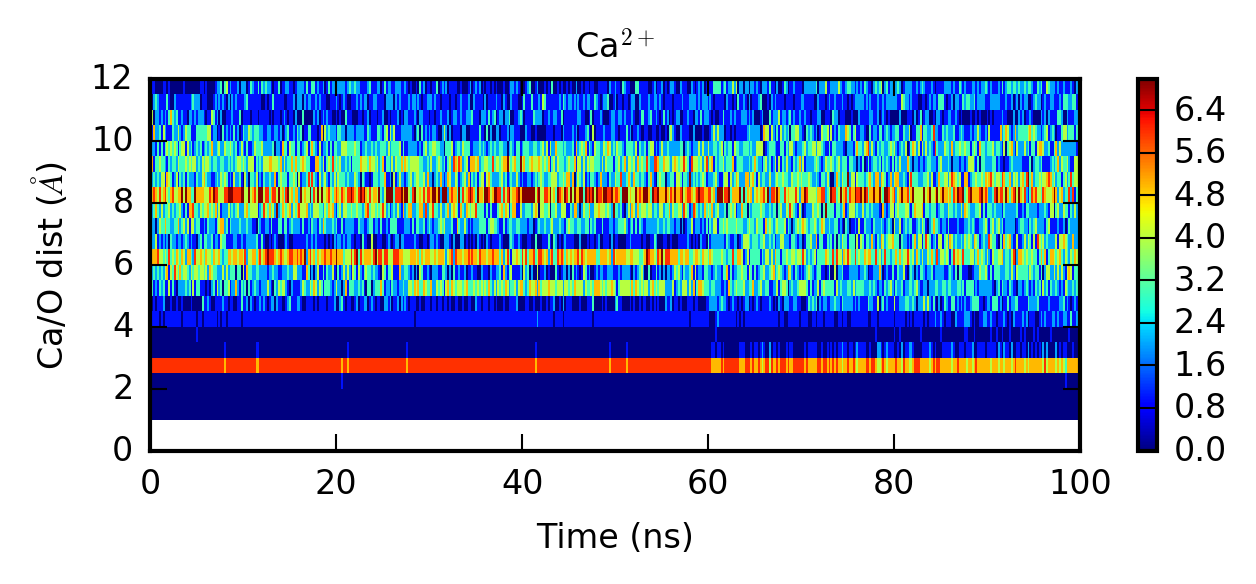

In [162]:
def plotOxyDensity(grid_t,grid_r,zs,title="NONE"):
  ylimLim = [0,7]
  xlimLim = [0,12]
  nCalCoord = 1.
  matplotlib.rcParams['figure.figsize'] = (5,1.6)
  scaleByCoordinationNumber=nCalCoord
  ar = scaleByCoordinationNumber*np.sum(zs,axis=0)
  font = {'size'   : 8}
  matplotlib.rc('font', **font)
  # density plot
  #plt.subplot(211)
  plt.title(title, **font)
  plt.xlabel("Time (ns)")
  plt.ylabel("Ca/O dist ($\AA$)", **font)
  plt.xlim([0,100])
  plt.pcolormesh(grid_t*pf.FRAME_TO_TIME,grid_r,ar.transpose())
  plt.colorbar()
  plt.clim([0,7])

plotOxyDensity(timeaxis,CaOaxis,density,title=r'Ca$^{2+}$')
###



In [163]:
#Ca1data=[]
#Kdata=[]
Mgdata=[]
Mgdata.append(timeaxis)
Mgdata.append(CaOaxis)
Mgdata.append(density)
#Ca2data=[]
#Ca2data.append(timeaxis)
#Ca2data.append(CaOaxis)
#Ca2data.append(density)

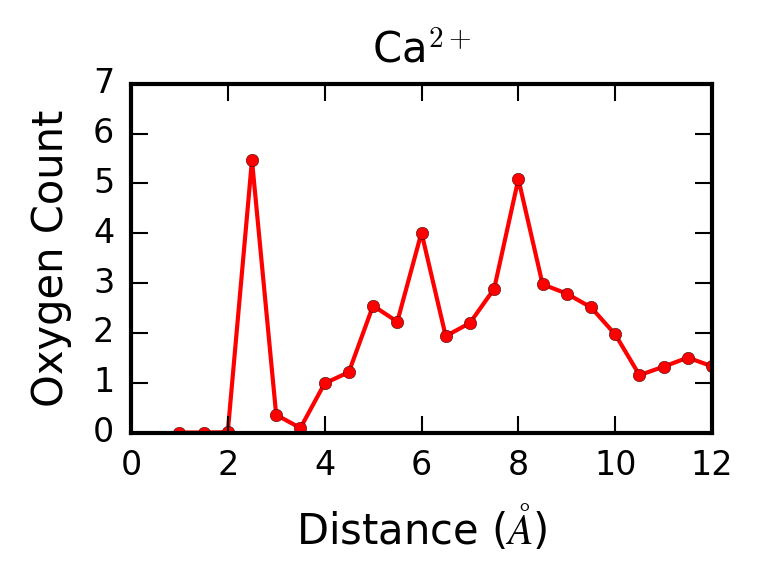

In [165]:
def rdf(grid_t,grid_r,zs,color="None",title="NONE"):
  # histogram plot
  #plt.subplot(212)
  ylimLim = [0,7]
  xlimLim = [0,12]
  scaleByCoordinationNumber=1
  ar = scaleByCoordinationNumber*np.sum(zs,axis=0)
  font = {'size'   : 10}
  histo=np.sum(ar,axis=1)
  nTs  = np.shape(ar)[1]
  plt.plot(grid_r[0,:],histo/nTs,'-o',color=color,markersize=3,markeredgewidth=0.1)
  matplotlib.rcParams['figure.figsize'] = (2.5,1.5)
  plt.ylabel("Oxygen Count", **font)
  plt.xlabel(r'Distance ($\AA$)',**font)
  plt.xticks(fontsize=8) 
  plt.yticks(fontsize=8)
  plt.title(title,**font)
  plt.ylim(ylimLim)
  plt.xlim(xlimLim)
   # save data
  l=np.mean(ar,axis=1) #Same as summing up and averaging over nTs.  See above.
  s=np.std(ar,axis=1)
  j=np.zeros([np.shape(l)[0],3])
  j[:,0]=grid_r[0,:]
  j[:,1]=l
  j[:,2]=s

  np.savetxt(title+".txt",j)
  #plt.gcf().savefig(title+".png",dpi=300.)
rdf(Mgdata[0],Mgdata[1],Mgdata[2],color="red",title=r'Ca$^{2+}$')


In [115]:
def plotOxyDensity(grid_t,grid_r,zs,title="NONE"):
  ylimLim = [0,7]
  xlimLim = [0,12]
  nCalCoord = 1.

  scaleByCoordinationNumber=nCalCoord
  ar = scaleByCoordinationNumber*np.sum(zs,axis=0)
  font = {'weight' : 'bold',
        'size'   : 12}
  matplotlib.rc('font', **font)
  # density plot
  plt.subplot(211)
  plt.title(title, **font)
  plt.xlabel("Time (ns)")
  plt.ylabel("Ca/O dist ($\AA$)", **font)
  plt.pcolormesh(grid_t/500.,grid_r,ar.transpose())
  plt.colorbar()
  plt.clim([0,7])

  # histogram plot
  plt.subplot(212)
  histo=np.sum(ar,axis=1)
  nTs  = np.shape(ar)[1]
  plt.plot(grid_r[0,:],histo/nTs)
  plt.ylabel("Oxygen Count", **font)
  plt.ylim(ylimLim)
  plt.xlim(xlimLim)
  plt.gcf().savefig(title+".png",dpi=300.)

  # save data
  l=np.mean(ar,axis=1) #Same as summing up and averaging over nTs.  See above.
  s=np.std(ar,axis=1)
  j=np.zeros([np.shape(l)[0],3])
  j[:,0]=grid_r[0,:]
  j[:,1]=l
  j[:,2]=s

  np.savetxt(title+".txt",j)
  return ar


In [3]:
def plotAveOxyDensity(ofname1,ofname2,ofname3,ofname4,ofname5,ofname6,save,title="NONE"):
 o1=np.loadtxt(ofname1,usecols=(0,1,2))
 o2=np.loadtxt(ofname2,usecols=(0,1,2))
 o3=np.loadtxt(ofname3,usecols=(0,1,2))
 o4=np.loadtxt(ofname4,usecols=(0,1,2))
 o5=np.loadtxt(ofname5,usecols=(0,1,2))
 o6=np.loadtxt(ofname6,usecols=(0,1,2))

 data1 = np.zeros([np.shape(o1)[0],3])
 data1[:,0] = o1[:,1]; data1[:,1] = o2[:,1]; data1[:,2] = o3[:,1]
 mean1 = np.mean(data1,axis=1)
 std1 = np.std(data1,axis=1)
    
    
 data2 = np.zeros([np.shape(o4)[0],3])
 data2[:,0] = o4[:,1]; data2[:,1] = o5[:,1]; data2[:,2] = o6[:,1]
 mean2 = np.mean(data2,axis=1)
 std2 = np.std(data2,axis=1)
 font = {'weight' : 'bold',
        'size'   : 12}
 matplotlib.rc('font', **font)
 plt.errorbar(x=o1[:,0],y=mean1,yerr=std1,fmt='b-', label="Ca")
 plt.errorbar(x=o4[:,0],y=mean2,yerr=std2,fmt='r-',label="Mg")
 plt.ylim([0,7])
 plt.xlim([1.0,13])
 plt.legend(loc=0)
 plt.title(title, **font)
 plt.xlabel('Ion/Oxygen Distance ($\AA$)', **font)
 plt.ylabel('Oxygen Count', **font)
 outFile=save+".png"
 plt.gcf().savefig(outFile, dpi=300)


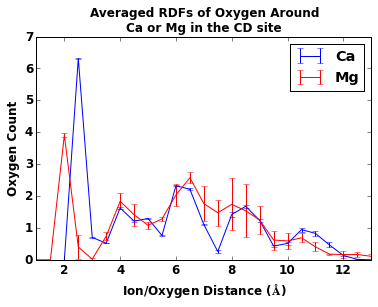

In [6]:
ofname1 = "/net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/CAWT/CDA_CAWT_CD_1.txt"
ofname2 = "/net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/CAWT/CDA_CAWT_CD_2.txt"
ofname3 = "/net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/CAWT/CDA_CAWT_CD_3.txt"
ofname4 = "/net/share/anku223/mdjobsbpv/MGWT_redo/CDA_MGCD_redo_1.txt"
ofname5 = "/net/share/anku223/mdjobsbpv/MGWT_redo/CDA_MGCD_redo_2.txt"
ofname6 = "/net/share/anku223/mdjobsbpv/MGWT_redo/CDA_MGCD_redo_3.txt"

plotAveOxyDensity(ofname1,ofname2,ofname3,ofname4,ofname5,ofname6,save="CDHAND_AV_RDF_CA_MG",title="Averaged RDFs of Oxygen Around \nCa or Mg in the CD site")